In [76]:
#Credit for code in this cell goes to /u/NomadNella 
# https://www.reddit.com/r/IPython/comments/3lpwl9/easiest_way_to_hide_your_input_in_code_cells/
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [32]:
from spectral import *
import pyfftw as fft
import numpy as np
from scipy import fftpack as ft
import h5py
import matplotlib.pyplot as plt

from skimage import io, exposure, img_as_uint
from sklearn import metrics
import pyfftw
import HyperSpecApp as HSA
spectral.settings.WX_GL_DEPTH_SIZE=16


## Import some helper functions to ease readability

In [2]:
import hs_imFFTW as hs

## 1.1 Read in training data
Spectral python trains on one data cube at a time.  We're going to cheat by concatenating our data into a (h, w, L/*N) datacube.

In [3]:
train_data = hs.getData(filename='/home/crob/Projects/HyperSpecData/HYPER_SPEC_TRAIN.h5', dat_idx= 25*49, lab_idx=49)
print(np.shape(train_data['dcb']))

(443, 313, 25)


ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 427.79910278320312]
    G: [0.0, 427.79910278320312]
    B: [0.0, 427.79910278320312]

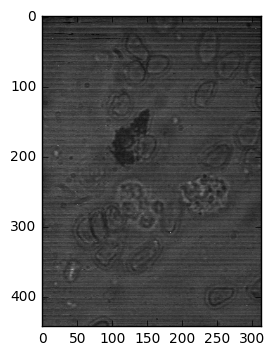

In [4]:
imshow(train_data['dcb'][:,:,18])

25


ImageView object:
  Display bands       :  [0, 221.5, 442]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.078125, 932.26068115234375]
    G: [13.3511962890625, 1285.3345947265625]
    B: [8.6253662109375, 1493.775146484375]

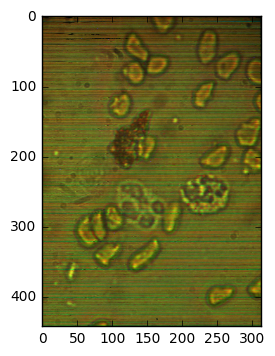

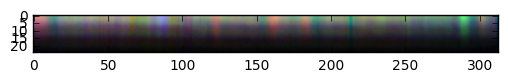

In [5]:
lam = np.shape(train_data['lambdas'])[0]
print(str(lam))
td = train_data['dcb'][:,:,0:25]

#train_data['dcb'] = np.reshape(train_data['dcb'], [443,313,lam,-1])
#gt = np.vstack(train_data['classLabels'])
#imshow(rs[:,:,:,1])
#imshow(td[:,:,:,0])
#imshow(gt)

img = train_data['dcb'][:,:,0:25]
imshow(img)
img1 = np.swapaxes(img,2,0)
imshow(img1)

The results of a 2d FFT applied to our data (Projected onto a 2d complex plane)

Below: The mask used to remove the vertical linear feature from the image 
(which is perpendicular to its real counterpart)


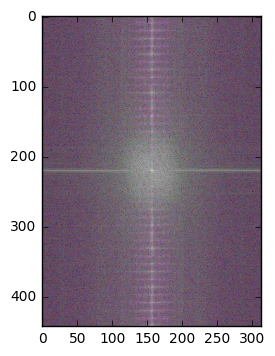

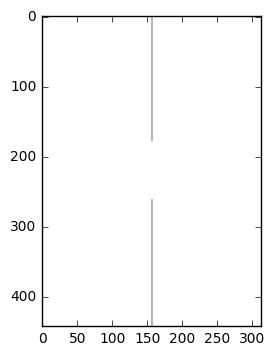

In [6]:
#FFT2 analysis of datacube (projected from each band onto the same 2d complex plane)

fft_img = hs.hsfft(img)
fft_log = np.log2(fft_img)
tmp = ft.fftshift(fft_log.real)
imshow(tmp)

#Generate the mask
mask = hs.genMask()
imshow(mask)

print("The results of a 2d FFT applied to our data (Projected onto a 2d complex plane)\n")
print("Below: The mask used to remove the vertical linear feature from the image \n(which is perpendicular to its real counterpart)")

### Before FFT Filtering

Our current image before application of FFT filter

Followed by the filter mask used to remove artifacts from the image


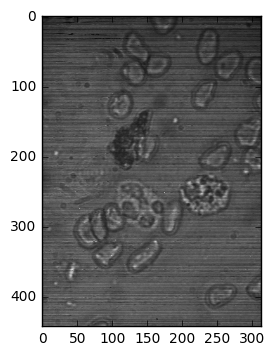

In [7]:
out_dcb = hs.dcbFilter(img)
imshow(img[:,:,13])


print("Our current image before application of FFT filter\n")
print("Followed by the filter mask used to remove artifacts from the image")

### After FFT FIltering

Our current image after application of FFT filter
Shape of Image: (443, 313, 25)


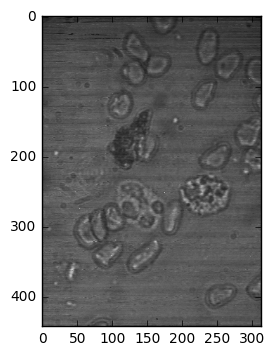

In [8]:
t = np.swapaxes(out_dcb, 0, 2) #rotate the datacube for next steps
t = np.swapaxes(t, 0, 1)

fftImg = t.real.astype(np.float32, copy=False)
imshow(fftImg[:,:,13])
print("Our current image after application of FFT filter")
print("Shape of Image: " + str(np.shape(fftImg)))

(443, 313)
Ground Truth mask of our data


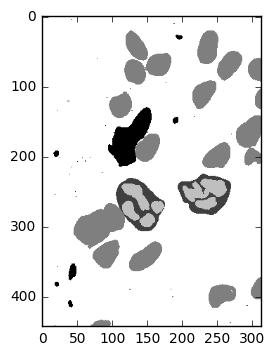

In [9]:
#img = train_data['dcb'][:,:,343,370]
gt = []
gt = HSA.adjustLabels(train_data['classLabels'])
print(np.shape(train_data['classLabels']))
#img_gt = train_data['classLabels'][:,:,11]
imshow(gt)
#bkgnd = gt == 0
print("Ground Truth mask of our data")

In [10]:
print(np.shape(gt))

(443, 313)


# ANALYSIS

### Perform Gaussian Maximum Likelihood classification (GMLC) on raw data

Shape of img: (443, 313, 25)
Shape of gt: (443, 313, 25)
Processing...  0.0%Processing... 25.0%Processing... 50.0%Processing... 75.0%Processing... 100.0%Processing...done   
Confusion Matrix:
[[ 3102     0     0     0     0]
 [    0  1902   173   571   704]
 [    0   465 13461  1547  2529]
 [    0   599   175  1755   791]
 [    0  9108 11973 14654 75150]] 

Classification report:
             precision    recall  f1-score   support

       null       1.00      1.00      1.00      3102
        WBC       0.16      0.57      0.25      3350
        RBC       0.52      0.75      0.61     18002
        NUC       0.09      0.53      0.16      3320
      BKGND       0.95      0.68      0.79    110885

avg / total       0.86      0.69      0.74    138659

Classification accuracy: 0.687802


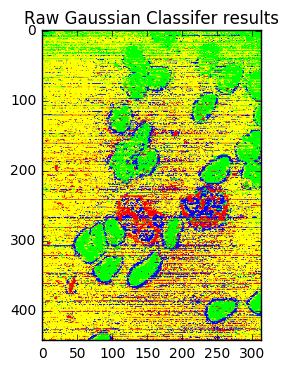

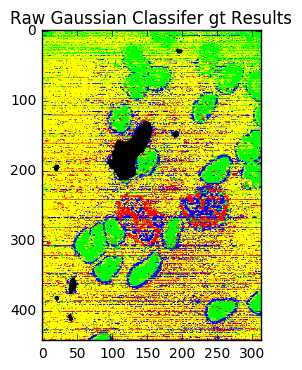

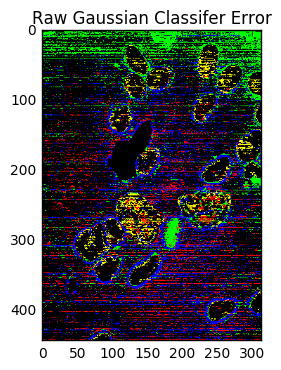

In [72]:
print("Shape of img: " + str(np.shape(img)) + "\r\n" + "Shape of gt: " + str(np.shape(img)))
(raw_results, raw_Errors) = HSA.runSpectral(img, gt, title="Raw")

test = np.reshape(raw_results, [-1])
g_t= np.reshape(gt, [-1])
#print(np.shape(test))
#print(np.shape(g_t))

print("Confusion Matrix:\n%s \n" %
     metrics.confusion_matrix(g_t,test))

target_names = ["null", "WBC", "RBC", "NUC", "BKGND"]
print("Classification report:\n%s" %
      metrics.classification_report(g_t, test, target_names=target_names))

print("Classification accuracy: %f" %
      metrics.accuracy_score(g_t, test))




### Implement FFT Filtering prior to GMLC

Processing...  0.0%Processing... 25.0%Processing... 50.0%Processing... 75.0%Processing... 100.0%Processing...done   
Confusion Matrix:
[[ 3102     0     0     0     0]
 [    0  2044   134   553   619]
 [    0   354 14357  1480  1811]
 [    0   570   132  1969   649]
 [    0  5605  8737  9581 86962]] 

Classification report:
             precision    recall  f1-score   support

       null       1.00      1.00      1.00      3102
        WBC       0.24      0.61      0.34      3350
        RBC       0.61      0.80      0.69     18002
        NUC       0.14      0.59      0.23      3320
      BKGND       0.97      0.78      0.87    110885

avg / total       0.88      0.78      0.82    138659

Classification accuracy: 0.782019


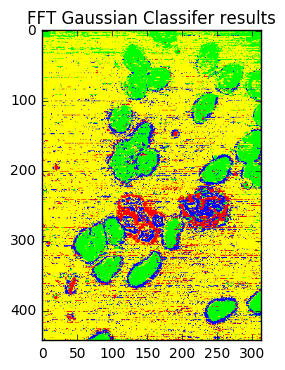

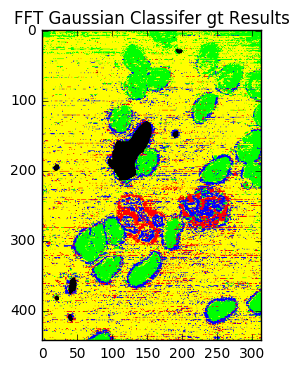

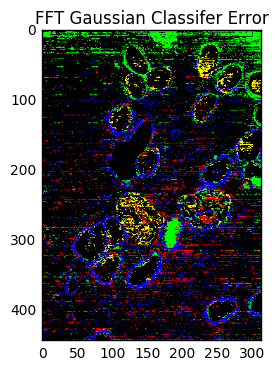

In [73]:
(fft_results, fft_Errors) = HSA.runSpectral(fftImg, gt, title="FFT")

test = np.reshape(fft_results, [-1])
g_t= np.reshape(gt, [-1])
#print(np.shape(test))
#print(np.shape(g_t))

print("Confusion Matrix:\n%s \n" %
     metrics.confusion_matrix(g_t,test))

target_names = ["null", "WBC", "RBC", "NUC", "BKGND"]
print("Classification report:\n%s" %
      metrics.classification_report(g_t, test, target_names=target_names))

print("Classification accuracy: %f" %
      metrics.accuracy_score(g_t, test))


### Implement PCA & remove poorest performing components prior to GMLC

Processing...  0.0%Processing... 25.0%Processing... 50.0%Processing... 75.0%Processing... 100.0%Processing...done   
Confusion Matrix:
[[ 3102     0     0     0     0]
 [    0  1904   176   550   720]
 [    0   475 13648  1500  2379]
 [    0   602   176  1719   823]
 [    0  9122 12224 14310 75229]] 

Classification report:
             precision    recall  f1-score   support

       null       1.00      1.00      1.00      3102
        WBC       0.16      0.57      0.25      3350
        RBC       0.52      0.76      0.62     18002
        NUC       0.10      0.52      0.16      3320
      BKGND       0.95      0.68      0.79    110885

avg / total       0.86      0.69      0.75    138659

Classification accuracy: 0.689476


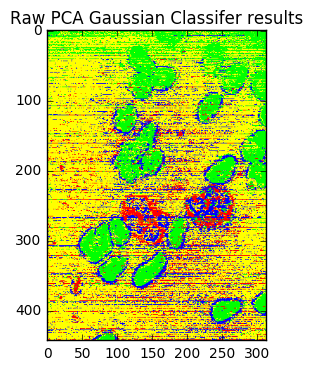

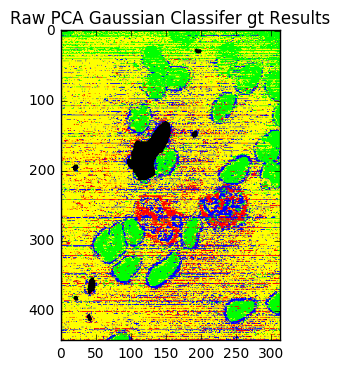

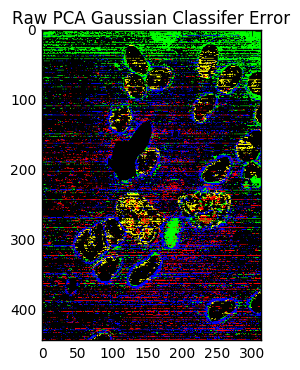

In [74]:
(raw_pc_results, raw_pc_Errors, raw_pc) = HSA.runPCA(img, gt, title="Raw")

test = np.reshape(raw_pc_results, [-1])
g_t= np.reshape(gt, [-1])
#print(np.shape(test))
#print(np.shape(g_t))

print("Confusion Matrix:\n%s \n" %
     metrics.confusion_matrix(g_t,test))

target_names = ["null", "WBC", "RBC", "NUC", "BKGND"]
print("Classification report:\n%s" %
      metrics.classification_report(g_t, test, target_names=target_names))

print("Classification accuracy: %f" %
      metrics.accuracy_score(g_t, test))


### Implement FFT filter & PCA prior to GMLC

Applying both operations to determine how performance is impacted.

Processing...  0.0%Processing... 25.0%Processing... 50.0%Processing... 75.0%Processing... 100.0%Processing...done   
Confusion Matrix:
[[ 3102     0     0     0     0]
 [    0  2048   136   552   614]
 [    0   341 14458  1482  1721]
 [    0   567   148  1934   671]
 [    0  5564  8724  9369 87228]] 

Classification report:
             precision    recall  f1-score   support

       null       1.00      1.00      1.00      3102
        WBC       0.24      0.61      0.35      3350
        RBC       0.62      0.80      0.70     18002
        NUC       0.15      0.58      0.23      3320
      BKGND       0.97      0.79      0.87    110885

avg / total       0.88      0.78      0.82    138659

Classification accuracy: 0.784442


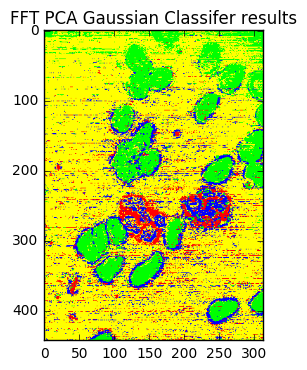

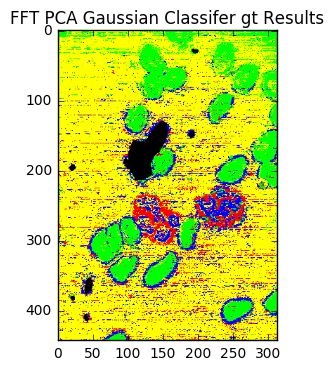

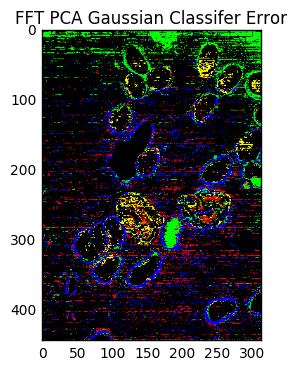

In [69]:
(fft_pc_results, fft_pc_Errors, fft_pc) = HSA.runPCA(fftImg, gt, title="FFT")

test = np.reshape(fft_pc_results, [-1])
g_t= np.reshape(gt, [-1])
#print(np.shape(test))
#print(np.shape(g_t))

print("Confusion Matrix:\n%s \n" %
     metrics.confusion_matrix(g_t,test))

target_names = ["null", "WBC", "RBC", "NUC", "BKGND"]
print("Classification report:\n%s" %
      metrics.classification_report(g_t, test, target_names=target_names))

print("Classification accuracy: %f" %
      metrics.accuracy_score(g_t, test))


Confusion Matrix:
[[ 3102     0     0     0     0]
 [    0  2048   136   552   614]
 [    0   341 14458  1482  1721]
 [    0   567   148  1934   671]
 [    0  5564  8724  9369 87228]] 

Classification report:
             precision    recall  f1-score   support

       null       1.00      1.00      1.00      3102
        WBC       0.24      0.61      0.35      3350
        RBC       0.62      0.80      0.70     18002
        NUC       0.15      0.58      0.23      3320
      BKGND       0.97      0.79      0.87    110885

avg / total       0.88      0.78      0.82    138659

Classification accuracy: 0.784442


In [15]:
print('SHAPE of results: ' + str(np.shape(fft_pc_results)))
print(fft_pc_results)

SHAPE of results: (443, 313)
[[2 2 2 ..., 2 2 2]
 [2 2 2 ..., 2 2 2]
 [2 2 2 ..., 2 2 2]
 ..., 
 [4 4 4 ..., 3 4 2]
 [4 4 4 ..., 4 4 4]
 [4 4 4 ..., 4 2 2]]


In [16]:
rbc_img = fft_pc_results == 2.0
wbc_img = fft_pc_results == 1.0
nuc_img = fft_pc_results == 3.0
bkg_img = fft_pc_results == 4.0
 
(wbc_o, wbc_c) = HSA.cleanResults(wbc_img)
(rbc_o, rbc_c) = HSA.cleanResults(rbc_img)
(nuc_o, nuc_c) = HSA.cleanResults(nuc_img)
(bkg_o, bkg_c) = HSA.cleanResults(bkg_img)

In [21]:
    def calcAccuracy(bin, gt, c):
        '''takes binary image of one class and compares it to the ground
        truth of that class.  Error is calculated based on weighted empirical error'''
        class_gt = gt[gt == c]
        class_match = class_gt[bin]
        class_err = class_match
        return class_err

ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 4.0]
    G: [0.0, 4.0]
    B: [0.0, 4.0]

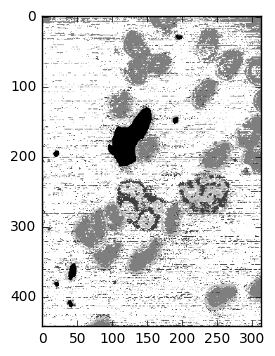

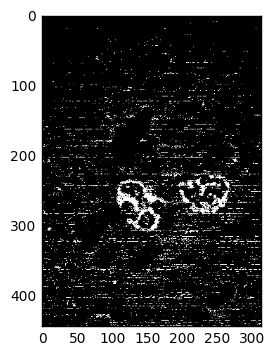

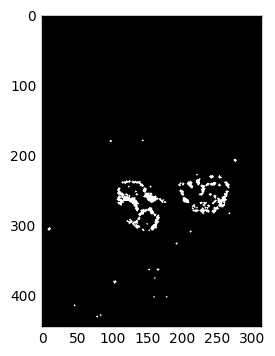

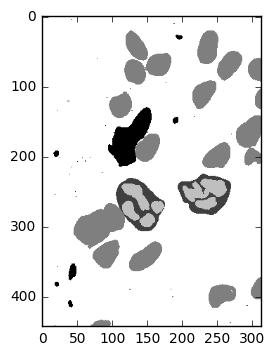

In [54]:
imshow(fft_pc_results)
imshow(wbc_img)
imshow(wbc_c)
imshow(gt)

In [51]:
#confusionmatrix needs 1d input vectors
test = np.reshape(fft_pc_results, [-1])
g_t= np.reshape(gt, [-1])
#print(np.shape(test))
#print(np.shape(g_t))

print("Confusion Matrix:\n%s \n" %
     metrics.confusion_matrix(g_t,test))

target_names = ["null", "WBC", "RBC", "NUC", "BKGND"]
print("Classification report:\n%s" %
      metrics.classification_report(g_t, test, target_names=target_names))

print("Classification accuracy: %f" %
      metrics.accuracy_score(g_t, test))

Confusion Matrix:
[[ 3102     0     0     0     0]
 [    0  2048   136   552   614]
 [    0   341 14458  1482  1721]
 [    0   567   148  1934   671]
 [    0  5564  8724  9369 87228]] 

Classification report:
             precision    recall  f1-score   support

       null       1.00      1.00      1.00      3102
        WBC       0.24      0.61      0.35      3350
        RBC       0.62      0.80      0.70     18002
        NUC       0.15      0.58      0.23      3320
      BKGND       0.97      0.79      0.87    110885

avg / total       0.88      0.78      0.82    138659

Classification accuracy: 0.784442


In [22]:
ti = HSA.combineLabels(rbc_o, wbc_o, nuc_o, bkg_img)
color = np.array([[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0]], dtype=np.ubyte)
tis = HSA.create_rgb(ti, color)


[[ 0.  2.  2. ...,  2.  2.  0.]
 [ 2.  2.  2. ...,  2.  2.  2.]
 [ 2.  2.  2. ...,  2.  2.  2.]
 ..., 
 [ 4.  4.  4. ...,  0.  4.  0.]
 [ 4.  4.  4. ...,  4.  4.  4.]
 [ 4.  4.  4. ...,  4.  0.  0.]]


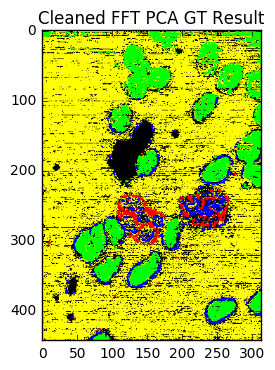

In [61]:
v6876 = imshow(tis, title="Cleaned FFT PCA GT Result")

In [62]:
test = np.reshape(ti, [-1])
print(np.shape(ti))

g_t= np.reshape(gt, [-1])
#print(np.shape(test))
#print(np.shape(g_t))

print("Confusion Matrix:\n%s \n" %
     metrics.confusion_matrix(g_t,test))

target_names = ["null", "WBC", "RBC", "NUC", "BKGND"]
print("Classification report:\n%s" %
      metrics.classification_report(g_t, test, target_names=target_names))

print("Classification accuracy: %f" %
      metrics.accuracy_score(g_t, test))

(443, 313)
Confusion Matrix:
[[ 3102     0     0     0     0]
 [  815  1652    35   234   614]
 [ 2080     3 13501   697  1721]
 [  989   282     5  1373   671]
 [17242   203  4177  2035 87228]] 

Classification report:
             precision    recall  f1-score   support

       null       0.13      1.00      0.23      3102
        WBC       0.77      0.49      0.60      3350
        RBC       0.76      0.75      0.76     18002
        NUC       0.32      0.41      0.36      3320
      BKGND       0.97      0.79      0.87    110885

avg / total       0.90      0.77      0.82    138659

Classification accuracy: 0.770639


### Post-processing
At first, it looks like the erosion operation negatively impacts accuracy.  This is due to the now unassigned examples (see the left most column of the confussion matrix) present in the image.  We must now re classify those pixels as Null in order to accurately represent performance improvements from the erosion operation.  Since those pixels which were eroded are no longer assigned to any class, they are added to the Null (ignored) class.

Pixels removed from erosion operation, now ignored


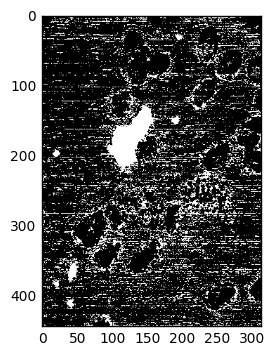

In [60]:
imshow(ti==0)
print("Pixels removed from erosion operation, now ignored")

In [63]:
test = np.reshape(ti, [-1])
print(np.shape(ti))

g_t= np.reshape(gt*(ti!=0), [-1])
#print(np.shape(test))
#print(np.shape(g_t))

print("Confusion Matrix:\n%s \n" %
     metrics.confusion_matrix(g_t,test))

target_names = ["null", "WBC", "RBC", "NUC", "BKGND"]
print("Classification report:\n%s" %
      metrics.classification_report(g_t, test, target_names=target_names))

print("Classification accuracy: %f" %
      metrics.accuracy_score(g_t, test))

(443, 313)
Confusion Matrix:
[[24228     0     0     0     0]
 [    0  1652    35   234   614]
 [    0     3 13501   697  1721]
 [    0   282     5  1373   671]
 [    0   203  4177  2035 87228]] 

Classification report:
             precision    recall  f1-score   support

       null       1.00      1.00      1.00     24228
        WBC       0.77      0.65      0.71      2535
        RBC       0.76      0.85      0.80     15922
        NUC       0.32      0.59      0.41      2331
      BKGND       0.97      0.93      0.95     93643

avg / total       0.93      0.92      0.93    138659

Classification accuracy: 0.922998


The null class is no longer factored into our report (as seen by the empty column on the left of the confusion matrix)

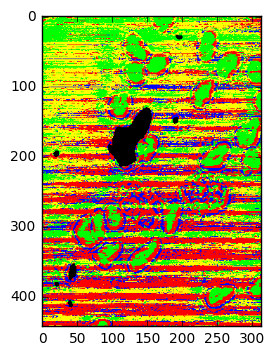

In [20]:
fft_classes = create_training_classes(fftImg, gt, True)
fft_means = np.zeros((len(fft_classes), fftImg.shape[2]), float)

for (e, g) in enumerate(fft_classes):
    fft_means[e] = g.stats.mean

fft_angles = spectral_angles(fftImg, fft_means)
fft_clmap = np.argmin(fft_angles, 2)
v20 = imshow(classes=((fft_clmap + 1) * (gt != 0)))